In [1]:
import glob

import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from unseen import fileio
from unseen import independence
from unseen import bias_correction
from unseen import similarity

Matplotlib is building the font cache; this may take a moment.


## Obs

In [2]:
agcd_file = '/g/data/ia39/agcd/post-processed/data/agcd_v2_precip_total_cafe-grid_monthly_1900-2020.zarr.zip'

In [3]:
#agcd_files = glob.glob('/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_month*.nc')
#agcd_files.sort()
#agcd_files

In [14]:
agcd_ds = fileio.open_dataset(agcd_file,
                              variables=['pr'],
                              shapefile='wheatbelt.zip',
                              spatial_agg='mean',
                              shape_label_header='region',
                              time_freq='A-DEC',
                              time_agg='sum',
                              input_freq='M',
                              metadata_file='../../config/dataset_agcd_monthly.yml',
                              complete_time_agg_periods=True)

In [15]:
agcd_ds

<xarray.Dataset>
Dimensions:  (region: 3, time: 121)
Coordinates:
  * time     (time) object 1900-12-31 00:00:00 ... 2020-12-31 00:00:00
  * region   (region) <U10 'south-west' 'south-east' 'north-east'
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 3), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:                      43596dc1-c56e-42a2-ba87-4e3b726a6e60

In [16]:
agcd_ds = agcd_ds.squeeze(drop=True)
agcd_ds = agcd_ds.dropna('time')

In [17]:
agcd_ds

<xarray.Dataset>
Dimensions:  (region: 3, time: 120)
Coordinates:
  * time     (time) object 1900-12-31 00:00:00 ... 2019-12-31 00:00:00
  * region   (region) <U10 'south-west' 'south-east' 'north-east'
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 3), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:                      43596dc1-c56e-42a2-ba87-4e3b726a6e60

In [8]:
agcd_ds = agcd_ds.compute()

In [18]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].sel({'region': 'south-west'}).values

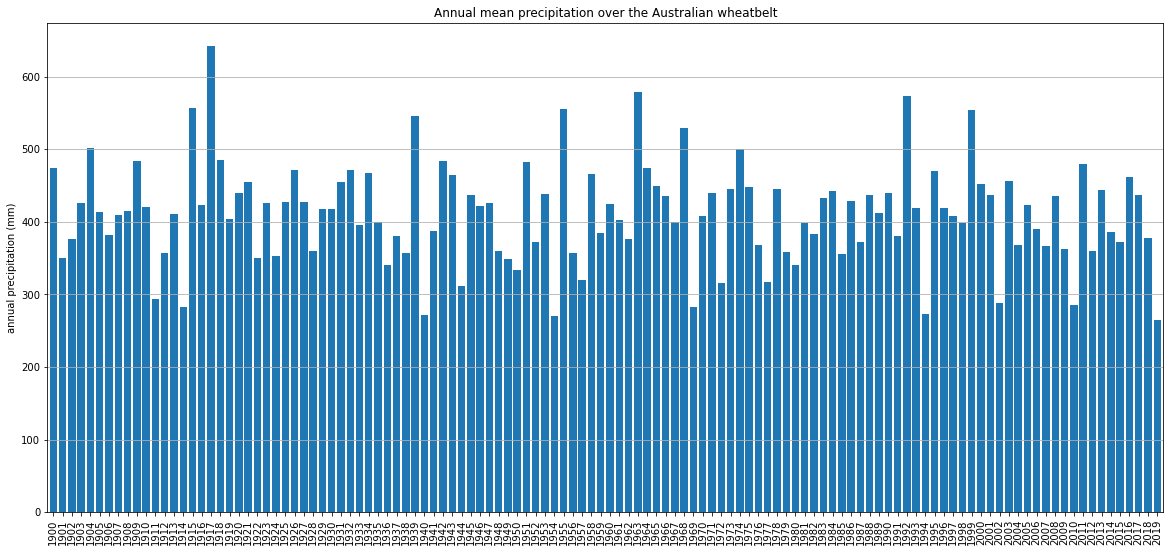

In [19]:
agcd_df['pr'].plot.bar(figsize=[20, 9], width=0.8)
#plt.axhline(mean_rainfall, color='0.5', linestyle='--')
plt.ylabel('annual precipitation (mm)')
plt.title(f'Annual mean precipitation over the Australian wheatbelt')
plt.grid(axis='y')
plt.show()

In [20]:
ranked_years = agcd_df['pr'].sort_values()
ranked_years.head(n=10)

2019    264.521324
1954    270.230225
1940    271.610384
1994    272.880286
1969    282.889858
1914    283.155850
2010    285.670296
2002    288.948922
1911    293.904527
1944    311.126848
Name: pr, dtype: float64

2019 was the driest year on record for Australia. Do the example UNSEEN analysis on that.

## Model

In [12]:
cafe_files = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20[1,2]*/atmos_isobaric_daily.zarr.zip')
cafe_files.sort()
cafe_files

['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20100501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20101101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20110501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20111101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20120501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20121101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20130501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20131101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20140501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20141101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20150501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20151101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/d

In [13]:
cafe_files[0:4]

['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20100501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20101101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20110501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20111101/atmos_isobaric_daily.zarr.zip']

In [14]:
cafe_ds = fileio.open_mfforecast(cafe_files[0:4],
                                 variables=['pr'],
                                 spatial_coords=[-44, -11, 113, 154],
                                 shapefile='wheatbelt.zip',
                                 spatial_agg='mean',
                                 time_freq='A-DEC',
                                 time_agg='sum',
                                 input_freq='D',
                                 reset_times=True,
                                 metadata_file='../../config/dataset_cafe_monthly.yml',
                                 complete_time_agg_periods=True,
                                 units={'pr': 'mm day-1'},
                                 units_timing='middle')

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

In [15]:
cafe_ds = cafe_ds.squeeze(drop=True)

In [16]:
cafe_ds

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 4, lead_time: 11)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 2010-05-01 00:00:00 ... 2011-11-01 00:00:00
    time       (lead_time, init_date) object 2010-05-01 12:00:00 ... 2021-11-...
Data variables:
    pr         (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 1, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [17]:
cafe_ds = cafe_ds.compute()

In [18]:
cafe_ds['pr'].isel({'ensemble': 1, 'init_date': 2}).values

array([         nan, 429.2410556 , 448.1055927 , 392.47674908,
       320.43731937, 388.42072205, 391.39005458, 588.05048476,
       631.06439354, 525.56643862,          nan])

In [19]:
# Bias correction
correction_method = 'additive'
bias = bias_correction.get_bias(cafe_ds['pr'], agcd_ds['pr'], correction_method, time_rounding='A', time_period=['2010-01-01', '2020-12-31'])
cafe_da_bc = bias_correction.remove_bias(cafe_ds['pr'], bias, correction_method)

In [20]:
cafe_da_bc = cafe_da_bc.compute()

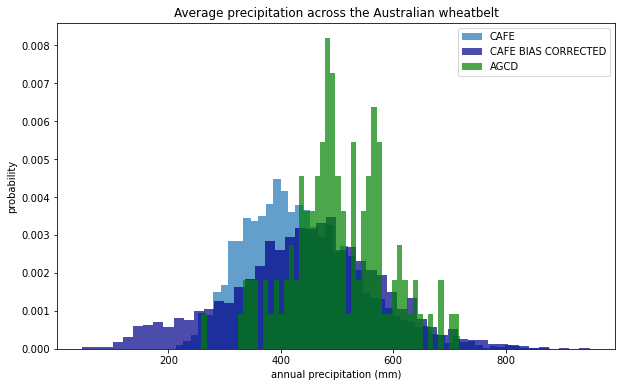

In [21]:
fig = plt.figure(figsize=[10, 6])
cafe_ds['pr'].plot.hist(bins=50, density=True, label='CAFE', alpha=0.7)
cafe_da_bc.plot.hist(bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7)
agcd_ds['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the Australian wheatbelt')
plt.legend()
#plt.savefig('australia_precip_histogram.png',
#            bbox_inches='tight', facecolor='white', dpi=200)
plt.show()

In [24]:
# Similarity testing
similarity_ds = similarity.univariate_ks_test(cafe_da_bc, agcd_ds, 'pr')

In [25]:
similarity_ds['pval'].values

array([1.33673043e-04, 4.70644782e-03, 3.07626589e-07, 2.40462872e-10,
       2.59502439e-02, 7.85557451e-03, 7.90478794e-14, 3.33066907e-16,
       3.33066907e-16])

In [27]:
# Independence testing
mean_correlations, null_correlation_bounds = independence.run_tests(cafe_da_bc)

In [28]:
mean_correlations

{5: <xarray.DataArray (lead_time: 11)>
 dask.array<mean_agg-aggregate, shape=(11,), dtype=float64, chunksize=(11,), chunktype=numpy.ndarray>
 Coordinates:
   * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10,
 11: <xarray.DataArray (lead_time: 11)>
 dask.array<mean_agg-aggregate, shape=(11,), dtype=float64, chunksize=(11,), chunktype=numpy.ndarray>
 Coordinates:
   * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10}

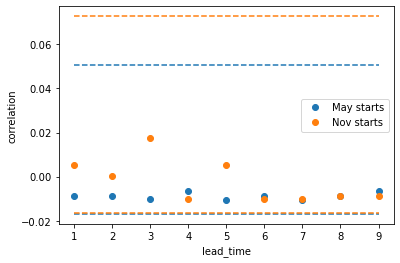

In [29]:
independence.create_plot(mean_correlations, null_correlation_bounds, 'independence.png')